In [16]:
%matplotlib inline

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import scipy
import numpy
from pyamg.gallery import linear_elasticity, poisson
from pyamg import smoothed_aggregation_solver, rootnode_solver

# Create problem definition
def laplace_eq(nx=40, ny=40, xr=(0.0,2.0), yr=(0.0,1.0)):
    (sx, ex) = xr
    (sy, ey) = yr
    dx = (ex - sx)/(nx+1)
    dy = (ey - sy)/(ny-1)
 
    Ap=-numpy.zeros((nx*ny))
    Aw=-numpy.ones((nx*ny))*dy*dy
    Ae=-numpy.ones((nx*ny))*dy*dy
    An=-numpy.ones((nx*ny))*dx*dx
    As=-numpy.ones((nx*ny))*dx*dx
    b=numpy.zeros((nx*ny))


    for i in range(0,nx):
        As[(i-1)*ny]=0
        An[i*ny-1]=0

    for j in range(0,ny):
        b[j]=0
        b[j+(nx-1)*ny]=j/(ny-1.)*dy*dy

    for i in range(0,nx):
        for j in range(0,ny):
            ij=(i-1)*ny+j
            Ap[ij]=-Aw[ij]-Ae[ij]-An[ij]-As[ij]

    Im1=numpy.arange(0,nx*ny-1)
    Ip1=numpy.arange(1,nx*ny)
    Imy=numpy.arange(0,nx*ny-ny)
    Ipy=numpy.arange(ny,nx*ny)
    I=numpy.arange(0,nx*ny)
    Aw=coo_matrix((Aw[ny:],(Ipy,Imy)),shape=(nx*ny,nx*ny))
    As=coo_matrix((As[1:],(Ip1,Im1)),shape=(nx*ny,nx*ny))
    Ap=coo_matrix((Ap,(I,I)),shape=(nx*ny,nx*ny))
    An=coo_matrix((An[:nx*ny-1],(Im1,Ip1)),shape=(nx*ny,nx*ny))
    Ae=coo_matrix((Ae[:nx*ny-ny],(Imy,Ipy)),shape=(nx*ny,nx*ny))
    A=Aw+As+Ap+An+Ae
    p=spsolve(A,b)
    
    return A, b, p
    
# Plot as mesh
def mesh_3d_plot(p, nx=40, ny=40, xr=(0.0,2.0), yr=(0.0,1.0)):
    (sx, ex) = xr
    (sy, ey) = yr
    x = numpy.linspace(int(sx),int(ex),nx+2)
    y = numpy.linspace(int(sy),int(ey),ny)
    X, Y = numpy.meshgrid(x,y)
    X=numpy.transpose(X);
    Y=numpy.transpose(Y);
    pr=p.reshape(nx,ny);
    p=numpy.zeros((nx+2,ny));
    p[1:nx+1,0:ny]=pr;
    p[nx+1,0:ny]=numpy.arange(0,ny)/(ny-1.);

    pi=numpy.pi;
    pd=0;
    for ii in range(0,50):
        i = 2*ii+1;
        pd+=1/(i*pi)**2/numpy.sinh(2*i*pi)*numpy.sinh(i*pi*X)*numpy.cos(i*pi*Y);
    px=X/4-4*pd;
    print numpy.linalg.norm(p-px)/numpy.linalg.norm(px)

    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, p, rstride=1, cstride=1, cmap=cm.coolwarm)
    ax.set_zlim3d(0, 1)
    ax.view_init(elev=50., azim=-130.)
    pyplot.show()

# pyamg rootnode_solver
def amg_solver(A, b, cg=False, name='amg', tol=1e-10):
    
    mls = rootnode_solver(A)
    print mls
    
    # Solve Ax = b
    residuals = []
    if cg:
        x = mls.solve(b, tol=tol, accel='cg', residuals=residuals)
    else :
        x = mls.solve(b, tol=tol, accel=None, residuals=residuals)

    
    # Compute relative residuals
    residuals  = numpy.array(residuals)/residuals[0]  
    
    # Plot convergence history
    import pylab
    pylab.figure()
    pylab.title('Convergence History (%s)' % name)
    pylab.xlabel('Iteration')
    pylab.ylabel('Relative Residual')
    pylab.semilogy(residuals,  label='Residual',  linestyle='None', marker='.')
    pylab.legend()
    pylab.show()

In [2]:
A, b, p = laplace_eq()

In [3]:
A.shape

(1600, 1600)

In [4]:
b.shape

(1600,)

In [5]:
p.shape

(1600,)

0.00760962945146


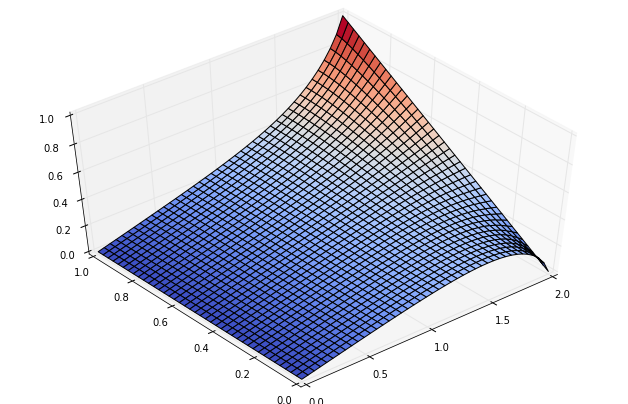

In [6]:
mesh_3d_plot(p)

multilevel_solver
Number of Levels:     2
Operator Complexity:  1.302
Grid Complexity:      1.175
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         1600         7840 [76.80%]
    1          280         2368 [23.20%]



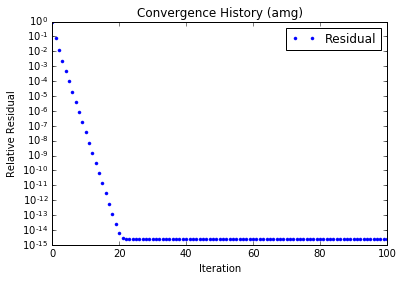

In [23]:
amg_solver(A, b, cg=False, tol=1e-15)

multilevel_solver
Number of Levels:     2
Operator Complexity:  1.302
Grid Complexity:      1.175
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         1600         7840 [76.80%]
    1          280         2368 [23.20%]



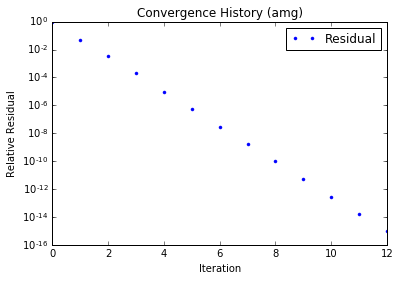

In [26]:
amg_solver(A, b, cg=True, tol=1e-15)